In [1]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from tbats import TBATS

In [2]:
df = pickle.load( open( "Files and Viz/seattle_data.pkl", "rb" ) )

In [3]:
df.shape

(47424, 11)

## Try tbats using a subset of the data: February 2021

In [4]:
small_df = df.iloc[-672:]

In [5]:
small_df.head()

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND
46752,2021-02-05 00:20:00,2021-02-05,47.0,0.0,77.0,BKN,30.10,10.0,South,11.0,1348.0
46753,2021-02-05 01:53:00,2021-02-05,47.0,0.0,80.0,OVC,30.06,10.0,Variable,6.0,1366.0
46754,2021-02-05 02:53:00,2021-02-05,47.0,0.0,80.0,OVC,30.03,10.0,South,15.0,1399.0
46755,2021-02-05 03:53:00,2021-02-05,47.0,0.0,83.0,OVC,30.03,10.0,South,13.0,1379.0
46756,2021-02-05 04:53:00,2021-02-05,47.0,0.0,86.0,FEW,30.04,10.0,South,9.0,1320.0


In [6]:
small_df.reset_index(inplace=True, drop=True)

**Initialize train and test set**

In [7]:
y_to_train = small_df.DEMAND.iloc[:int(.8*len(small_df))]
y_to_test = small_df.DEMAND.iloc[-int(.2*len(small_df)):] # last 20% of data for testing

In [8]:
y_to_train, y_to_test

(0      1348.0
 1      1366.0
 2      1399.0
 3      1379.0
 4      1320.0
         ...  
 532    1324.0
 533    1288.0
 534    1232.0
 535    1154.0
 536    1096.0
 Name: DEMAND, Length: 537, dtype: float64,
 538    1015.0
 539    1005.0
 540     993.0
 541    1017.0
 542    1050.0
         ...  
 667    1276.0
 668    1291.0
 669    1279.0
 670    1246.0
 671    1208.0
 Name: DEMAND, Length: 134, dtype: float64)

In [ ]:
# Fit the model
estimator = TBATS(seasonal_periods=[24, 24*7])
model = estimator.fit(y_to_train)

In [9]:
# Forecast 134 hours ahead (size of test set)
y_forecast = model.forecast(steps=134)

In [10]:
y_to_test.reset_index(inplace=True, drop=True)

**Plot TBATS forecast**

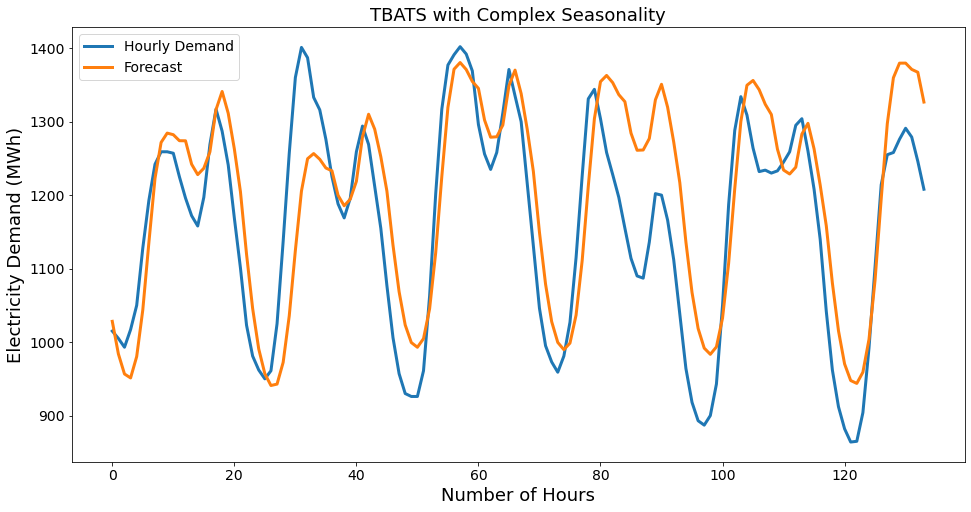

In [11]:
fig = plt.figure(figsize=(16,8))
plt.plot(y_to_test,linewidth=3, label='Hourly Demand')
plt.plot(y_forecast, linewidth=3, label='Forecast')
plt.xlabel('Number of Hours', fontsize=18)
plt.ylabel('Electricity Demand (MWh)', fontsize=18)
plt.title('TBATS with Complex Seasonality', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

**Calculate RMSE**

In [12]:
mse = mean_squared_error(y_to_test, y_forecast)
rmse = np.sqrt(mse)
rmse

89.56586268545934

## Try sarimax with exogenous variables

**Get hourly temperatures**

In [13]:
exog_temps = small_df.Temperature.iloc[:int(.8*len(small_df))]

**Flag weekends as 1, weekdays as 0. Weekends = Saturdays and Sundays**

In [14]:
weekends = ['2021-02-06', '2021-02-07', '2021-02-13', '2021-02-14', '2021-02-20', '2021-02-21', '2021-02-27', '2021-02-28']

In [15]:
y_to_train.reset_index(inplace=True, drop=True)

In [16]:
small_df['WEEKENDS'] = [1 if x in weekends else 0 for x in small_df['SHORTDATE']]

<ipython-input-16-2ddc33a0b465>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['WEEKENDS'] = [1 if x in weekends else 0 for x in small_df['SHORTDATE']]


In [17]:
small_df.reset_index(inplace=True, drop=True)

In [18]:
exog_days = small_df.WEEKENDS.iloc[:int(.8*len(small_df))]

**Instantiate SARIMAX model with exogenous variable (parameters derived from grid search in other notebook)**

In [19]:
model = SARIMAX(endog=y_to_train, exog=exog_temps, order=(1,1,1), seasonal_order=(1,1,1,24)).fit(dis=-1)

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
forecast = model.get_forecast(exog=small_df.Temperature.iloc[-int(.2*len(small_df)):], steps=134)

**Plot SARIMAX forecast**

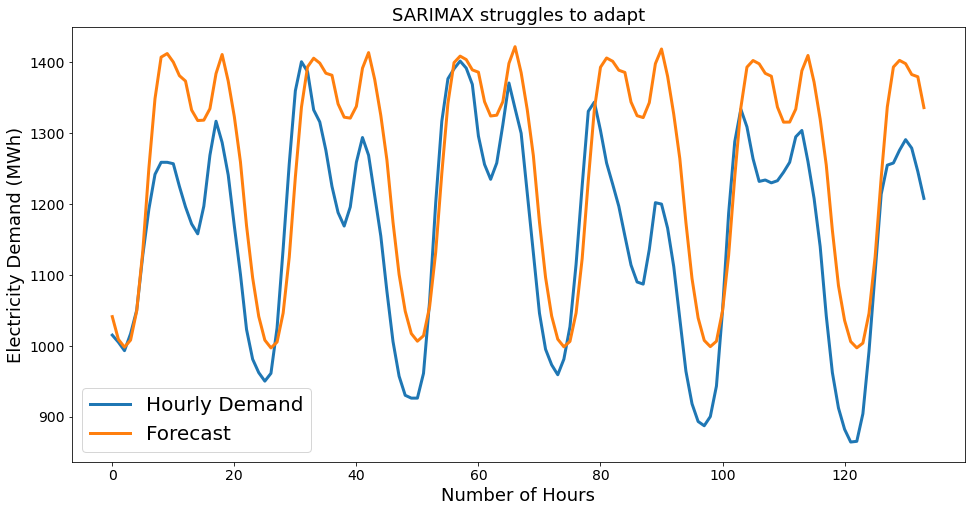

In [21]:
fig = plt.figure(figsize=(16,8))
plt.plot(y_to_test.values,linewidth=3, label='Hourly Demand')
plt.plot(forecast.predicted_mean.values, linewidth=3, label='Forecast')
plt.xlabel('Number of Hours', fontsize=18)
plt.ylabel('Electricity Demand (MWh)', fontsize=18)
plt.title('SARIMAX struggles to adapt', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)

**Calculate RMSE**

In [ ]:
mse = mean_squared_error(y_to_test, forecast.predicted_mean)
rmse = np.sqrt(mse)
rmse

**try sarimax with exog days: binary indicator of weekday or weekend**

In [23]:
model = SARIMAX(endog=y_to_train, exog=exog_days, order=(1,1,1), seasonal_order=(1,1,1,24)).fit(dis=-1)

In [24]:
forecast = model.get_forecast(exog=small_df.WEEKENDS.iloc[-int(.2*len(small_df)):], steps=134)

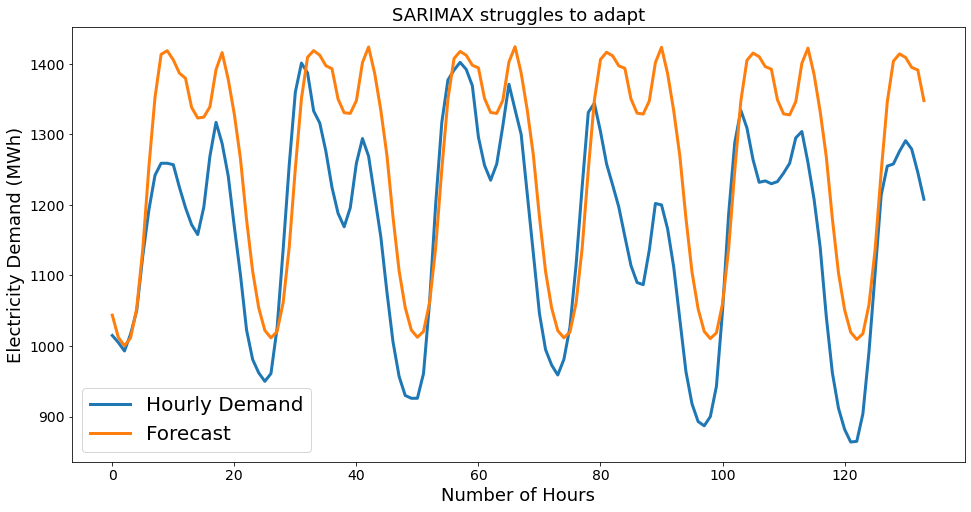

In [25]:
fig = plt.figure(figsize=(16,8))
plt.plot(y_to_test.values,linewidth=3, label='Hourly Demand')
plt.plot(forecast.predicted_mean.values, linewidth=3, label='Forecast')
plt.xlabel('Number of Hours', fontsize=18)
plt.ylabel('Electricity Demand (MWh)', fontsize=18)
plt.title('SARIMAX struggles to adapt', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)

In [26]:
mse = mean_squared_error(y_to_test, forecast.predicted_mean)
rmse = np.sqrt(mse)
rmse

130.71248441711143

***Very similar to sarimax with temps exog. Slightly higher RMSE for sarimax with days exog***

## Try ARIMA

In [27]:
model = ARIMA(endog=y_to_train, order=(1,1,0)).fit()

In [28]:
forecast = model.get_forecast(steps=134)

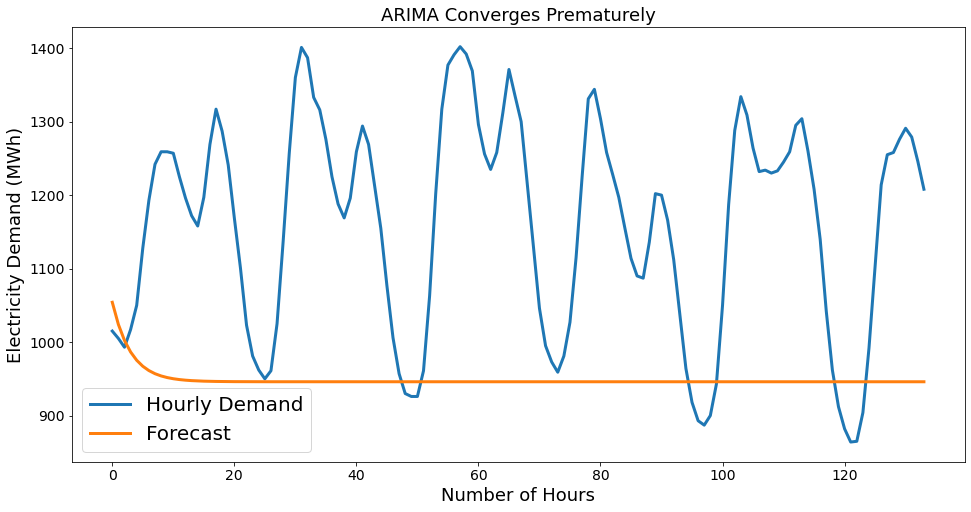

In [29]:
fig = plt.figure(figsize=(16,8))
plt.plot(y_to_test.values,linewidth=3, label='Hourly Demand')
plt.plot(forecast.predicted_mean.values, linewidth=3, label='Forecast')
plt.xlabel('Number of Hours', fontsize=18)
plt.ylabel('Electricity Demand (MWh)', fontsize=18)
plt.title('ARIMA Converges Prematurely', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)

In [30]:
mse = mean_squared_error(y_to_test, forecast.predicted_mean)
rmse = np.sqrt(mse)
rmse

257.773795669378

## Time to try prophet!

In [31]:
train_df = small_df.iloc[:int(.801*len(small_df))]

In [32]:
train_df

,DATE,SHORTDATE,Temperature,Precipitation,Humidity,Condition,Pressure,Visibility,WindDirection,WindSpeed,DEMAND,WEEKENDS
0,2021-02-05 00:20:00,2021-02-05,47.0,0.0,77.0,BKN,30.10,10.0,South,11.0,1348.0,0
1,2021-02-05 01:53:00,2021-02-05,47.0,0.0,80.0,OVC,30.06,10.0,Variable,6.0,1366.0,0
2,2021-02-05 02:53:00,2021-02-05,47.0,0.0,80.0,OVC,30.03,10.0,South,15.0,1399.0,0
3,2021-02-05 03:53:00,2021-02-05,47.0,0.0,83.0,OVC,30.03,10.0,South,13.0,1379.0,0
4,2021-02-05 04:53:00,2021-02-05,47.0,0.0,86.0,FEW,30.04,10.0,South,9.0,1320.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
533,2021-02-27 05:53:00,2021-02-27,35.0,0.0,93.0,FEW,30.16,10.0,East,3.0,1288.0,1
534,2021-02-27 06:53:00,2021-02-27,33.0,0.0,96.0,FEW,30.18,8.0,South,3.0,1232.0,1
535,2021-02-27 07:53:00,2021-02-27,33.0,0.0,96.0,SCT,30.20,9.0,South,5.0,1154.0,1
536,2021-02-27 08:53:00,2021-02-27,38.0,0.0,89.0,FEW,30.23,10.0,South,5.0,1096.0,1


In [33]:
test_data = small_df.DEMAND.iloc[-int(.20*len(small_df)):]

In [34]:
test_data

538    1015.0
539    1005.0
540     993.0
541    1017.0
542    1050.0
        ...  
667    1276.0
668    1291.0
669    1279.0
670    1246.0
671    1208.0
Name: DEMAND, Length: 134, dtype: float64

In [35]:
test_data_dates = small_df.DATE.iloc[-int(.20*len(small_df)):]

In [36]:
prophet_df = train_df.copy()

In [37]:
prophet_df = prophet_df[['DATE', 'DEMAND']].rename(columns={'DATE':'ds', 'DEMAND':'y'})

In [38]:
prophet_df

,ds,y
0,2021-02-05 00:20:00,1348.0
1,2021-02-05 01:53:00,1366.0
2,2021-02-05 02:53:00,1399.0
3,2021-02-05 03:53:00,1379.0
4,2021-02-05 04:53:00,1320.0
...,...,...
533,2021-02-27 05:53:00,1288.0
534,2021-02-27 06:53:00,1232.0
535,2021-02-27 07:53:00,1154.0
536,2021-02-27 08:53:00,1096.0


In [39]:
model = Prophet()

In [40]:
model.fit(prophet_df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [41]:
future = pd.DataFrame(test_data_dates)

In [42]:
future.rename(columns={'DATE':'ds'}, inplace=True)

In [43]:
forecast = model.predict(future)

In [44]:
y_true = test_data.values
y_pred = forecast['yhat'].values

**Plot forecast**

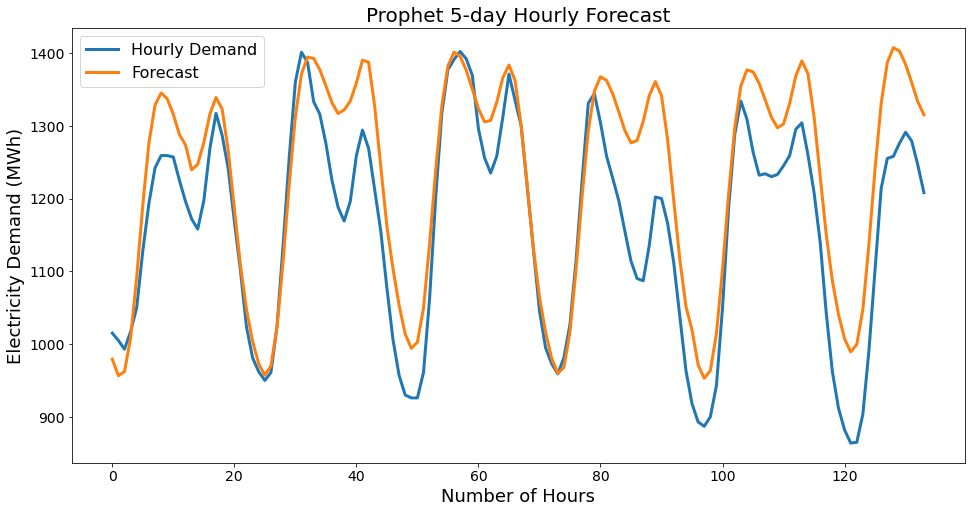

In [46]:
fig = plt.figure(figsize=(16,8))
plt.plot(y_true,linewidth=3, label='Hourly Demand')
plt.plot(y_pred, linewidth=3, label='Forecast')
plt.xlabel('Number of Hours', fontsize=18)
plt.ylabel('Electricity Demand (MWh)', fontsize=18)
plt.title('Prophet 5-day Hourly Forecast', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

**Calculate RMSE**

In [47]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
rmse

86.060116998025

***Prophet performed best with lowest RMSE***

### Calculate EIA Day-ahead Demand Forecast Model RMSE

In [48]:
df = pickle.load( open( "Files and Viz/new_electricity_data.pkl", "rb" ) )

In [49]:
df.shape

(50011, 1)

In [50]:
forecast = pd.read_csv('Files and Viz/Day-ahead_demand_forecast_for_Seattle_City_Light_(SCL)_hourly_-_UTC_time.csv', header=4)

In [51]:
forecast.shape

(49781, 2)

In [52]:
forecast.isna().sum()

Category                                     0
Series ID: EBA.SCL-ALL.DF.H megawatthours    0
dtype: int64

In [53]:
df.isna().sum()

DEMAND    0
dtype: int64

**EIA forecast dataset is of different length than historical demand dataset**

In [54]:
forecast['DATE']= pd.to_datetime(forecast['Category'])

In [55]:
forecast = forecast[['DATE','Series ID: EBA.SCL-ALL.DF.H megawatthours']]

In [56]:
forecast.head()

,DATE,Series ID: EBA.SCL-ALL.DF.H megawatthours
0,2021-03-21 07:00:00,962
1,2021-03-21 06:00:00,1022
2,2021-03-21 05:00:00,1075
3,2021-03-21 04:00:00,1111
4,2021-03-21 03:00:00,1106


In [57]:
forecast.rename(columns={'Series ID: EBA.SCL-ALL.DF.H megawatthours':'FORECAST'}, inplace=True)

In [58]:
# invert table
forecast = forecast[::-1]

In [59]:
forecast.reset_index(inplace=True, drop=True)

In [60]:
forecast.head()

,DATE,FORECAST
0,2015-07-01 08:00:00,865
1,2015-07-01 09:00:00,841
2,2015-07-01 10:00:00,790
3,2015-07-01 11:00:00,783
4,2015-07-01 12:00:00,800


In [61]:
df.head()

,DEMAND
DATE,
2015-07-01 08:00:00+00:00,873.0
2015-07-01 09:00:00+00:00,833.0
2015-07-01 10:00:00+00:00,802.0
2015-07-01 11:00:00+00:00,796.0
2015-07-01 12:00:00+00:00,807.0


In [62]:
df.reset_index(inplace=True)

In [63]:
df.DATE.iloc[0] == forecast.DATE.iloc[0]

False

In [64]:
str(df.DATE.iloc[0])[:13]

'2015-07-01 08'

In [65]:
# convert dates to strings to match on other df

df.DATE = df.DATE.apply(lambda x: str(x)[:13])

In [66]:
forecast.DATE = forecast.DATE.apply(lambda x: str(x)[:13])

In [67]:
forecast

,DATE,FORECAST
0,2015-07-01 08,865
1,2015-07-01 09,841
2,2015-07-01 10,790
3,2015-07-01 11,783
4,2015-07-01 12,800
...,...,...
49776,2021-03-21 03,1106
49777,2021-03-21 04,1111
49778,2021-03-21 05,1075
49779,2021-03-21 06,1022


In [68]:
# join datasets on DATE

d = df.set_index('DATE').join(forecast.set_index('DATE'))

In [69]:
d

,DEMAND,FORECAST
DATE,,
2015-07-01 08,873.0,865.0
2015-07-01 09,833.0,841.0
2015-07-01 10,802.0,790.0
2015-07-01 11,796.0,783.0
2015-07-01 12,807.0,800.0
...,...,...
2021-03-18 10,855.0,845.0
2021-03-18 11,859.0,851.0
2021-03-18 12,892.0,890.0


In [70]:
# filter out missing values before computing rmse

d = d.loc[(~d.DEMAND.isna()) & (~d.FORECAST.isna())]

In [71]:
d.shape

(49687, 2)

In [72]:
mse = mean_squared_error(d.DEMAND, d.FORECAST)
rmse = np.sqrt(mse)
rmse

98.72214252394181

## Bar plots of all percent errors. PE = RMSE/mean of test set

### First plot includes underperforming ARIMA

In [73]:
average = y_to_test.mean()
x = ['ARIMA','SARIMAX', 'TBATS', 'Prophet', 'EIA']
y = [257.77,97.22, 89.56, 86.06, 98.72]/average*100

In [74]:
threshold = (86.06/average)*100

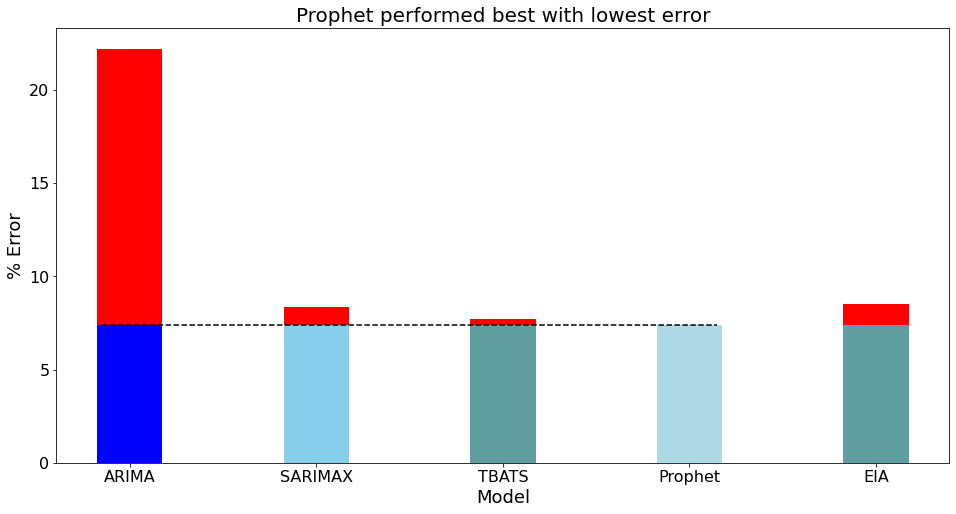

In [75]:
values = y

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(x, below_threshold, 0.35, color=['blue','skyblue','cadetblue', 'lightblue','cadetblue'])
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)
plt.xticks(np.arange(0,5,1),x, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Model', fontsize=18)
plt.ylabel('% Error', fontsize=18)
plt.title('Prophet performed best with lowest error', fontsize=20)

# horizontal line indicating the threshold
ax.plot([-.15, 3.15], [threshold, threshold], "k--")

### Bar plot without ARIMA

In [105]:
average = y_to_test.mean()
x = ['SARIMAX', 'TBATS', 'Prophet', 'EIA']
y = [97.22, 89.56, 86.06, 98.72]/average*100

In [106]:
threshold = (86.06/average)*100

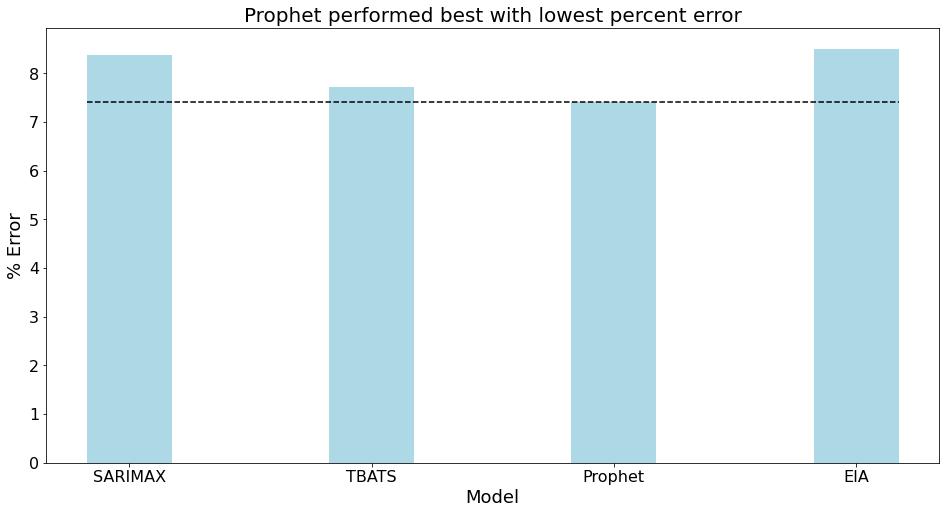

In [109]:
values = y

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(x, below_threshold, 0.35, color=['lightblue','lightblue','lightblue', 'lightblue'])
ax.bar(x, above_threshold, 0.35, color='lightblue',
        bottom=below_threshold)
plt.xticks(np.arange(0,4,1),x, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Model', fontsize=18)
plt.ylabel('% Error', fontsize=18)
plt.title('Prophet performed best with lowest percent error', fontsize=20)

# horizontal line indicating the threshold
ax.plot([-.175, 3.175], [threshold, threshold], "k--")

## Calculate forecast bias for each model

**Prophet**

In [81]:
forecast_errors = [y_true[i]-y_pred[i] for i in range(len(y_true))]
bias = sum(forecast_errors) * 1.0/len(y_true)
print('Bias: %f' % bias)

Bias: -65.233636


**EIA**

In [82]:
calc = d.loc[(d.index > '2021-02-05') & (d.index < '2021-02-27')]

In [83]:
forecast_errors = [calc.DEMAND[i]-calc.FORECAST[i] for i in range(len(calc.DEMAND))]
bias = sum(forecast_errors) * 1.0/len(calc.DEMAND)
print('Bias: %f' % bias)

Bias: 55.812500


**TBATS**

In [84]:
forecast_errors = [y_to_test[i]-y_forecast[i] for i in range(len(y_to_test))]
bias = sum(forecast_errors) * 1.0/len(y_to_test)
print('Bias: %f' % bias)

Bias: -32.591862
